In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import pandas as pnd
from pathlib import Path
from time import time
from MomentLearn import utils
from MomentLearn import model as model_utils
from MomentLearn.model import Net
import prody as pd

In [2]:
X_names, mapk_pdb_id_to_class = utils.get_example_metadata()
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
mapping = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

In [15]:
start_time = time()
pdbs = []
for i, (pdb_id, chain) in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins fetched in {(time() - start_time):.2f} seconds")
    pdbs.append(pd.parsePDB(pdb_id, chain=chain))

In [4]:
from geometricus import MomentInvariants, SplitType, MomentType

invariants_kmer = []
invariants_radius = []

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {(time() - start_time):.2f} seconds")
    invariants_kmer.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.KMER, split_size=27, moment_types=list(MomentType)))
    invariants_radius.append(MomentInvariants.from_prody_atomgroup(key, pdbs[i], split_type=SplitType.RADIUS, split_size=10, moment_types=list(MomentType)))


50 proteins in 8.55 seconds
100 proteins in 11.11 seconds
150 proteins in 13.55 seconds
200 proteins in 16.13 seconds
250 proteins in 18.61 seconds
300 proteins in 21.21 seconds
350 proteins in 24.34 seconds
400 proteins in 26.90 seconds
450 proteins in 29.41 seconds
500 proteins in 32.60 seconds


In [5]:
ind_moments_kmer = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 25).astype("float32") for x in invariants_kmer]
ind_moments_radius = [((np.sign(x.moments) * np.log1p(np.abs(x.moments))) / 10).astype("float32") for x in invariants_radius]
ind_moments = [np.hstack((ind_moments_kmer[i], ind_moments_radius[i])) for i in range(len(ind_moments_radius))]

In [11]:
no_out_channels = 1
epoch = 20_000
model = Net(no_out_channels, ind_moments[0].shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

No handles with labels found to put in legend.


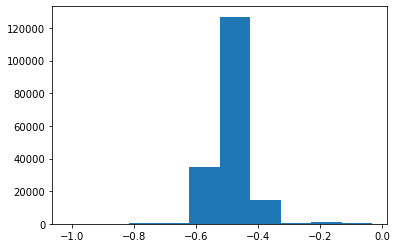

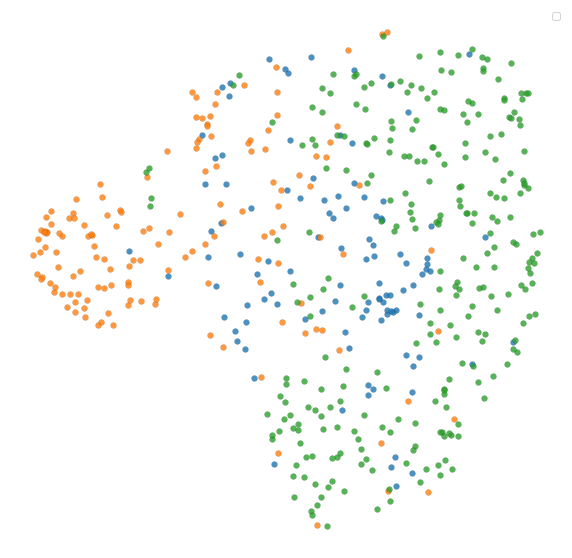

In [12]:
utils.plot_umap(ind_moments, model, mapping)

In [13]:
current_losses = []
for e in range(epoch):
    x, dist, y = model_utils.sample_random_moment_with_close_distant(ind_moments,
                                                                     batch=300,
                                                                     number_of_moments=ind_moments[0].shape[1])
    x, dist, y = model(x, dist, y)

    loss = model_utils.loss_func(x, dist, y)
    optimizer.zero_grad()
    loss.backward()
    current_losses.append(loss.item())
    optimizer.step()

    if e % 1000 == 0:
        print(np.mean(current_losses))
        current_losses = []

0.2150733470916748
0.10880149271711707
0.06985258681699634
0.06733353471755982
0.06588476699590683
0.06398756310343742
0.06193548136949539
0.06076911244913936
0.058792126040905716
0.0579051849283278
0.05688063453882933
0.05591634123399854
0.0557404184602201
0.0552814756706357
0.05466310069337487
0.05484105248004198
0.05448542752861977
0.054326787061989304
0.05429564720764756
0.05408861707523465


No handles with labels found to put in legend.


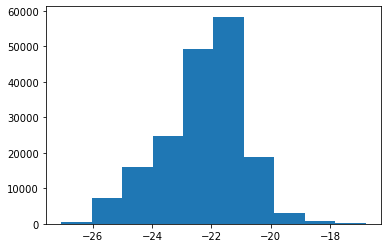

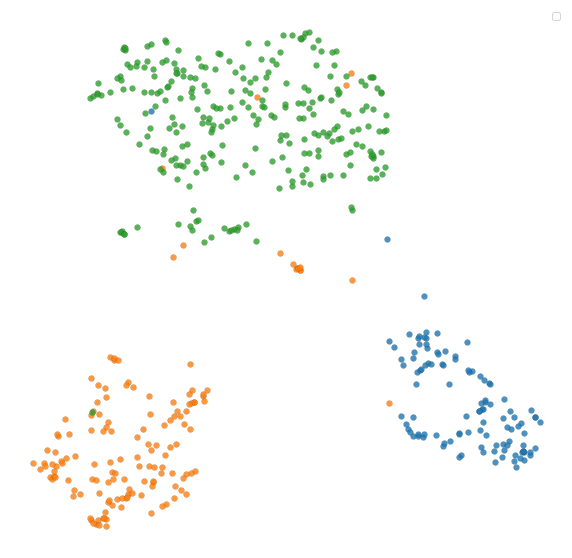

In [14]:
utils.plot_umap(ind_moments, model, mapping)